## Imports

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-colors")
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

import scipy.stats as stats
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Define paths

In [5]:
DATA_PATH = Path("../data")

## Import data

In [11]:
df_pen = pd.read_csv(DATA_PATH / "penguins.csv")

In [7]:
df_pen.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [9]:
df_pen.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

## Clean data

In [12]:
df_pen = (df_pen
          .dropna(
              subset=["bill_length_mm", "flipper_length_mm", "body_mass_g", "sex"],
              how="any"
          )
         )

## Summary statistics for weight

In [13]:
(df_pen
 .loc[:, ["species", "body_mass_g"]]
 .groupby("species")
 .agg(["mean", "std", "count"])
)

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

In [17]:
(df_pen
 .groupby("species")
 .agg(
     num_penguins=("body_mass_g", "count"),
     mean_weight=("body_mass_g", "mean"),
     std_weight=("body_mass_g", "std")
 )
)

,num_penguins,mean_weight,std_weight
species,,,
Adelie,146,3706.164384,458.620135
Chinstrap,68,3733.088235,384.335081
Gentoo,119,5092.436975,501.476154


## Model single species

In [19]:
adelie_weight = df_pen.query("species == 'Adelie'")["body_mass_g"].values

In [20]:
with pm.Model() as m_30:
    # Priors
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    # Likelihood
    w = pm.Normal("w", 
                  mu=μ,
                  sd=σ,
                  observed=adelie_weight
                 )
    # Sample prior
    prior = pm.sample_prior_predictive(5000)
    # Sample posterior
    post = pm.sample(return_inferencedata=False, chains=4)
    # Create inference data
    idata_adelie = az.from_pymc3(prior=prior, trace=post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [31]:
idata_adelie.prior.μ

<xarray.DataArray 'μ' (chain: 1, draw: 5000)>
array([[ 2348.56598923, -1280.93822767,  2727.02521366, ...,
         7200.89643783,   -33.46603032,  2461.86804105]])
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999

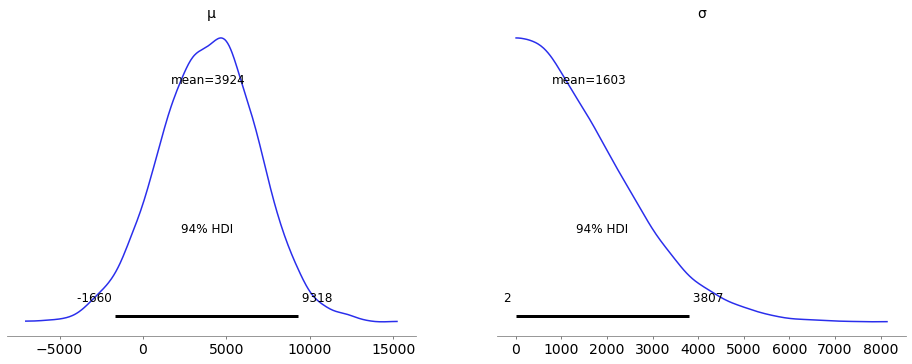

In [35]:
az.plot_posterior(idata_adelie.prior, var_names=["μ", "σ"]);

In [38]:
az.summary(idata_adelie, var_names=["μ", "σ"], group="posterior")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3705.744,40.189,3637.492,3788.229,0.674,0.476,3569.0,2368.0,1.0
σ,462.849,27.715,410.840,513.309,0.467,0.331,3531.0,2393.0,1.0


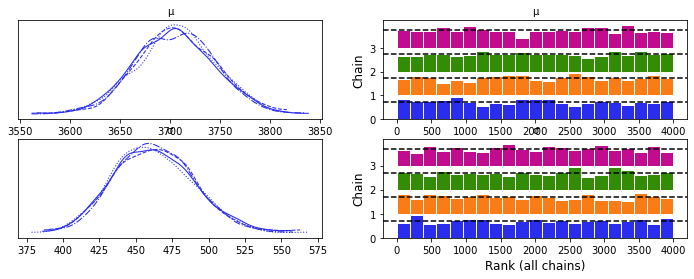

In [42]:
az.plot_trace(idata_adelie, var_names=["μ", "σ"], kind="rank_bars");

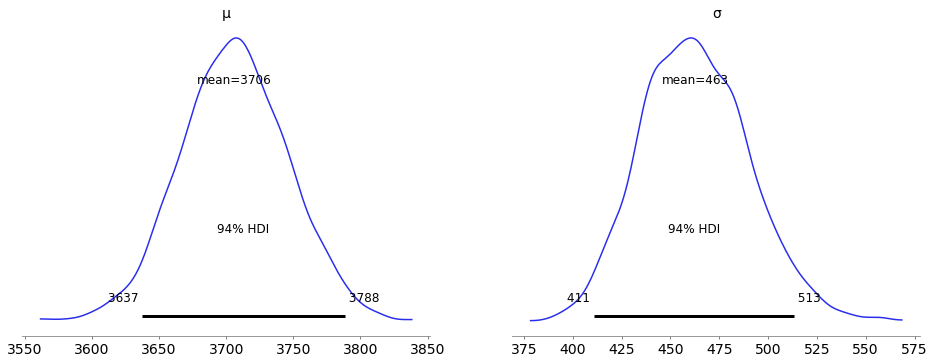

In [44]:
az.plot_posterior(idata_adelie.posterior,  var_names=["μ", "σ"]);

## Model all species

In [45]:
df_pen = (df_pen
          .assign(
              species=pd.Categorical(df_pen["species"])
          )
         )

In [57]:
cats = df_pen["species"].cat.categories.values
cat_codes = df_pen["species"].cat.codes.values
w_obs = df_pen["body_mass_g"].values

In [56]:
coords = {
    "species": cats
}

In [58]:
with pm.Model(coords=coords) as m_31:
    # Priors
    μ = pm.Normal("μ", 4000, 2000, dims="species")
    σ = pm.HalfStudentT("σ", 100, 2000, dims="species")
    # Likelihood
    w = pm.Normal("w",
                  mu=μ[cat_codes],
                  sd=σ[cat_codes],
                  observed=w_obs
                 )
    # Inference
    prior = pm.sample_prior_predictive(5000)
    post = pm.sample(return_inferencedata=False, chains=4)
    idata_all = az.from_pymc3(prior=prior, trace=post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [59]:
az.summary(idata_all)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[Adelie],3705.915,39.168,3632.436,3776.782,0.520,0.368,5701.0,3113.0,1.0
μ[Chinstrap],3733.243,48.967,3645.723,3830.504,0.544,0.385,8162.0,3083.0,1.0
μ[Gentoo],5091.666,46.237,5003.653,5179.412,0.593,0.420,6083.0,3066.0,1.0
σ[Adelie],463.028,27.343,412.246,513.659,0.338,0.242,6776.0,3087.0,1.0
σ[Chinstrap],390.650,35.029,326.496,454.933,0.481,0.347,5455.0,3299.0,1.0
σ[Gentoo],506.390,33.590,444.115,569.946,0.443,0.317,5895.0,3003.0,1.0


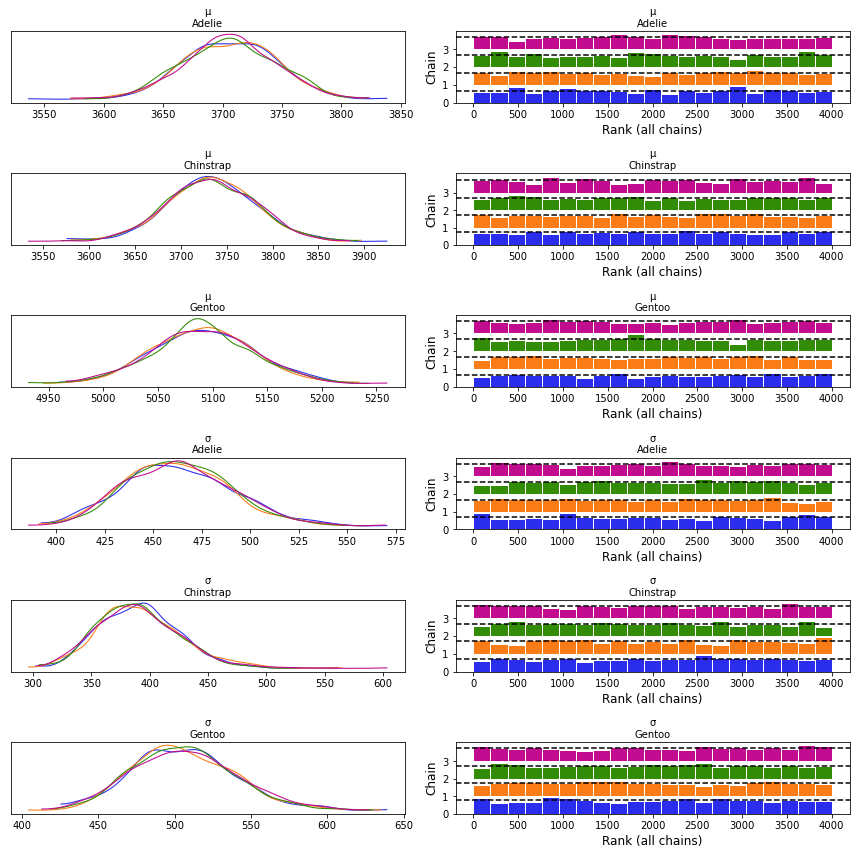

In [64]:
az.plot_trace(idata_all, kind="rank_bars", compact=False)
plt.tight_layout()

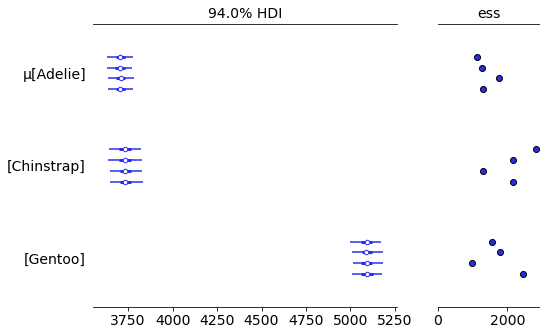

In [68]:
az.plot_forest(idata_all, ess=True, var_names=["μ"]);

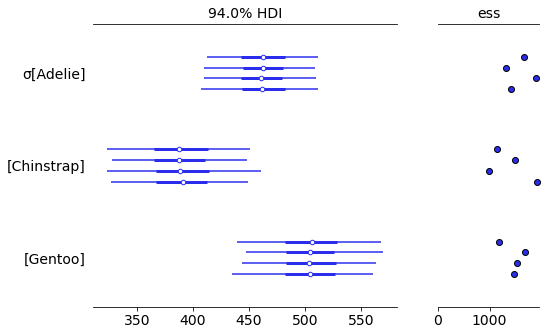

In [69]:
az.plot_forest(idata_all, ess=True, var_names=["σ"]);